Visualize the scalability as a function of dimension in the linear case

In [6]:
import numpy as np
%matplotlib inline  
import glob,h5py,os,re
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20
#http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
import cPickle as pickle
from datasets.synthp import params_synthetic
from utils.misc import getPYDIR,getConfigFile,readPickle, loadHDF5

#visualize synthetic results
def getCode(f):
    params  =  readPickle(getConfigFile(f))[0]
    code    = params['inference_model']+'-'+params['var_model']
    code    = code.replace('structured','ST').replace('mean_field','MF')
    return code
results = {}
results[10] = {}
results[10]['name']     = 'synthetic15'
results[10]['maxEPOCH'] = 200
results[10]['dim']      = 10
results[100] = {}
results[100]['name']     = 'synthetic16'
results[100]['maxEPOCH'] = 200
results[100]['dim']      = 100
results[250] = {}
results[250]['name']     = 'synthetic27'
results[250]['maxEPOCH'] = 200
results[250]['dim']      = 250

ntrainlist = [10,100,1000]
SAVEDIR = '../../expt-synthetic-fast/chkpt-'

DATADIR = getPYDIR()+'/datasets/synthetic/'

baselines = {}
for dset in results:
    bline = '../../expt-synthetic-fast/baselines/'+results[dset]['name']+'-baseline.h5'
    if os.path.exists(bline):
        bb = loadHDF5(bline)
        print bb.keys()
    else:
        bb = None
    baselines[dset] = bb


from datasets.load import loadDataset
datasets = {}
dset_params = {}
for dset in results: 
    datasets[dset]    = loadDataset(results[dset]['name'])
    dset_params[dset] = params_synthetic[results[dset]['name']]

Found:  /data/ml2/rahul/theanomodels/datasets/synthetic//synthetic18.h5
Found:  /data/ml2/rahul/theanomodels/datasets/synthetic//synthetic19.h5
Found:  /data/ml2/rahul/theanomodels/datasets/synthetic//synthetic20.h5


In [9]:
#Visualizing epoch
getepoch = re.compile("-EP(.*)-")

def estimateMSE(mu_posterior, true_z):
    err_sum = np.square(mu_posterior-true_z).sum()
    return np.sqrt(np.square(mu_posterior-true_z.squeeze()).mean())

final_result = {}
ignored = 0
for dset in results:
    DIR = SAVEDIR+results[dset]['name']+'/'
    for f in glob.glob(DIR+'*-final.h5'):
        code = getCode(f)
        if code!='ST-R':
            ignored +=1
            continue
        params  = readPickle(getConfigFile(f))[0]
        Ntrain, dimstoc =  params['ntrain'],results[dset]['dim']
        alldata = loadHDF5(f)
        #print f,alldata.keys()
        valid_mus= alldata['mu_posterior_valid'][-1]
        valid_zs = datasets[dimstoc]['valid_z']
        print Ntrain,dimstoc,  valid_mus.shape, valid_zs.shape
        rmse_train = estimateMSE(valid_mus,valid_zs)
        print rmse_train
        final_result['dim'+str(dimstoc)+'ntrain'+str(Ntrain)]= rmse_train
print ignored,' ignored'

10 10 (500, 25, 10) (500, 25, 10)
0.981814049597
100 10 (500, 25, 10) (500, 25, 10)
0.981765100916
1000 10 (500, 25, 10) (500, 25, 10)
0.981760031913
10 100 (500, 25, 100) (500, 25, 100)
0.983456427193
1000 100 (500, 25, 100) (500, 25, 100)
0.983420357791
100 100 (500, 25, 100) (500, 25, 100)
0.983437612098
100 250 (500, 25, 250) (500, 25, 250)
0.982943434674
10 250 (500, 25, 250) (500, 25, 250)
0.982955749653
1000 250 (500, 25, 250) (500, 25, 250)
0.982936344814
9  ignored


(0, 6)

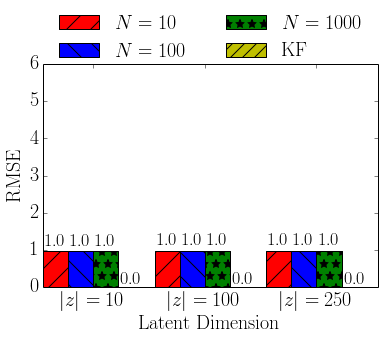

In [10]:
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.9       # the width of the bars

fig, ax = plt.subplots()
train10 = (final_result['dim10ntrain10'], final_result['dim100ntrain10'], final_result['dim250ntrain10'])
rects1 = ax.bar(ind, train10, width/4, color='r', hatch="/")

train100 = (final_result['dim10ntrain100'], final_result['dim100ntrain100'], final_result['dim250ntrain100'])
rects2 = ax.bar(ind + width/4, train100, width/4, color='b', hatch="\\")

train1000 = (final_result['dim10ntrain1000'], final_result['dim100ntrain1000'], final_result['dim250ntrain1000'])
rects3 = ax.bar(ind + 2*width/4, train1000, width/4, color='g', hatch="*")

if baselines[10] is None:
    KF = (0,0,0)
else:
    KF = (baselines[10]['valid_rmse'].sum(), baselines[100]['valid_rmse'].sum(), baselines[250]['valid_rmse'].sum())
rects4 = ax.bar(ind + 3*width/4, KF, width/4, color='y', hatch="//")

# add some text for labels, title and axes ticks
ax.set_xlabel('Latent Dimension')
ax.set_ylabel('RMSE')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('$|z|=10$', '$|z|=100$', '$|z|=250$'))

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('$N=10$', '$N=100$', '$N=1000$', 'KF'),
          loc='upper center', bbox_to_anchor=(0.5, 1.3),ncol=2, frameon=False)
def autolabel(rects):
    # attach some text labels
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.1f' % height,
                ha='center', va='bottom',size=18)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel
plt.ylim(0,6)

#plt.savefig('scaling-exact-inference.pdf',bbox_inches='tight')